In [ ]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator,TransformerMixin
from scipy.sparse import csr_matrix

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

from wordcloud import WordCloud

- Data contains various categorical, numerical and text features.

- We have to predict whether the project application will get accepted or not.

- https://www.kaggle.com/c/donorschoose-application-screening

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=15)

In [ ]:
X_train.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
414,ia,mrs,grades_prek_2,0,literacy_language math_science,literacy mathematics,i teach lower elementary active students it ha...,444.37


# **Set-1**

<h3>Encoding features:</h3>

- using column transformer to encode and stack features.
- making custom transformer for tfidf-w2v vectorizer and sentiment score (https://scikit-learn.org/stable/developers/develop.html)

In [ ]:
class TfidfW2vVectorizer(TfidfVectorizer,BaseEstimator,TransformerMixin):

  def __init__(self):
    super().__init__()
    
  def fit(self,raw_documents,y=None):
    with open('/content/drive/MyDrive/glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

    self.w2v_vectors_ = []  
    for word in list( super().fit(raw_documents).vocabulary_ ):
      if word in glove_words:
        self.w2v_vectors_.append(model[word])
      else:
        self.w2v_vectors_.append(np.zeros(300))  
    self.w2v_vectors_ = csr_matrix(self.w2v_vectors_)
    return self

  def transform(self,raw_documents):
    check_is_fitted(self,msg="fit raw_documents before transform")
    tfidf_vectors = super().transform(raw_documents)
    tfidf_w2v_vectors = ( np.dot( tfidf_vectors , self.w2v_vectors_ ) ) / ( tfidf_vectors.sum(axis=1) )
    return tfidf_w2v_vectors

  def fit_transform(self, raw_documents, y=None):
    return self.fit(raw_documents).transform(raw_documents)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
class SentimentScore( SentimentIntensityAnalyzer , BaseEstimator , TransformerMixin ):

  def __init__(self):
    super().__init__()

  def fit(self,raw_documents,y=None):
    return self

  def transform(self,raw_documents,y=None):
    sentiment_scores = []
    for sentence in raw_documents:
      sentiment_scores.append( list(super().polarity_scores(sentence).values()) )
    return np.array(sentiment_scores)

  def fit_transform(self, raw_documents, y=None):
    return self.fit(raw_documents).transform(raw_documents)

In [ ]:
transform_set1 = make_column_transformer(
    ( TfidfVectorizer(max_df=0.85,stop_words='english') , (6) ),  #tfidf on essay
    ( SentimentScore() , (6) ),                                   #sentiment score of essay
    ( OneHotEncoder(handle_unknown='ignore') , (0, 1, 2, 4, 5) ), #onehot encoding of categorical features
    ( MinMaxScaler() , (3,7) )                                    #normalizing numerical features
    )

<h3>Doing Gridsearch on Depth and min. sample split</h3>

In [ ]:
pipe_set1 = make_pipeline( transform_set1 , DecisionTreeClassifier(random_state=15) )
param = {'decisiontreeclassifier__max_depth':[1, 3, 10, 30],'decisiontreeclassifier__min_samples_split':[5, 10, 100, 500]}
clf_set1 = GridSearchCV( pipe_set1, param , cv=3, scoring='roc_auc', return_train_score=True,refit=False, error_score='raise',verbose=4) 
clf_set1.fit(X_train,y_train)

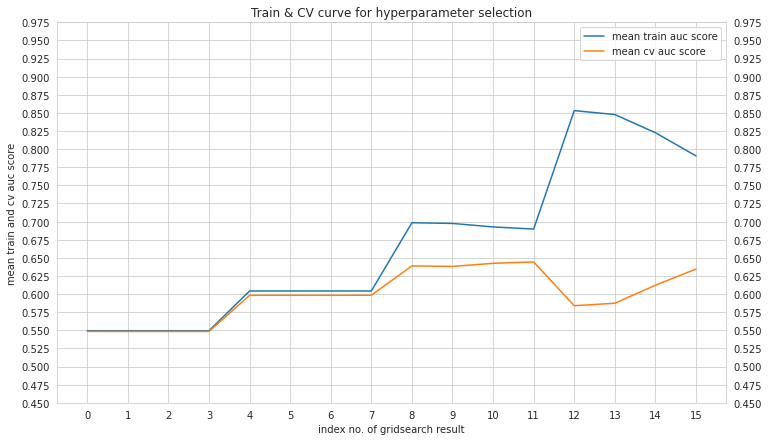

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(16), y=clf_set1.cv_results_['mean_train_score'], label='mean train auc score')
sns.lineplot(np.arange(16), y=clf_set1.cv_results_['mean_test_score'], label='mean cv auc score')
plt.xticks(np.arange(16))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index no. of gridsearch result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()



- Selecting Index no.11

In [ ]:
print('Maximum Depth:',clf_set1.cv_results_['param_decisiontreeclassifier__max_depth'][11])
print('Minimum Sample Split:',clf_set1.cv_results_['param_decisiontreeclassifier__min_samples_split'][11])
print('Train AUC:',clf_set1.cv_results_['mean_train_score'][11])
print('Test AUC:',clf_set1.cv_results_['mean_test_score'][11])

Maximum Depth: 10
Minimum Sample Split: 500
Train AUC: 0.6896920409542301
Test AUC: 0.6443674885568381


<h3>Heatmap</h3>

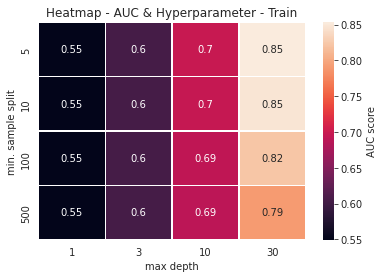

In [ ]:
auc = clf_set1.cv_results_['mean_train_score'].reshape(4,4).T
df = pd.DataFrame(auc,index=['5','10','100','500'], columns=['1','3','10','30'])
sns.heatmap(df,annot=True,linewidths=.3, cbar_kws={'label': 'AUC score'})
plt.title('Heatmap - AUC & Hyperparameter - Train')
plt.xlabel('max depth')
plt.ylabel('min. sample split')
plt.show()

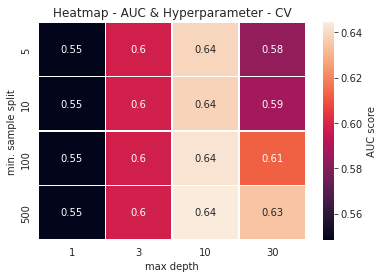

In [ ]:
auc = clf_set1.cv_results_['mean_test_score'].reshape(4,4).T
df = pd.DataFrame(auc,index=['5','10','100','500'], columns=['1','3','10','30'])
sns.heatmap(df,annot=True,linewidths=.3, cbar_kws={'label': 'AUC score'}) #https://stackoverflow.com/questions/45690898/create-a-heatmap-using-python
plt.title('Heatmap - AUC & Hyperparameter - CV')
plt.xlabel('max depth')
plt.ylabel('min. sample split')
plt.show()

<h3>Training on whole X_train:</h3>

In [ ]:
param={'decisiontreeclassifier__max_depth':10, 'decisiontreeclassifier__min_samples_split':500}

pipe_set1.set_params(**param)
pipe_set1.fit(X_train,y_train)
y_predict_train = pipe_set1.predict_proba(X_train)[:,1]
y_predict_test = pipe_set1.predict_proba(X_test)[:,1]
auc_score_set1_train = roc_auc_score(y_train, y_predict_train )
auc_score_set1_test = roc_auc_score(y_test, y_predict_test )
print('Train AUC Score:', auc_score_set1_train)
print('Test AUC Score:', auc_score_set1_test )

confusion_matrix_train_set1 = confusion_matrix(y_train,pipe_set1.predict(X_train),normalize='true')
print('Confusion Matrix - Train:\n',confusion_matrix_train_set1)
confusion_matrix_test_set1 = confusion_matrix(y_test,pipe_set1.predict(X_test),normalize='true')
print('Confusion Matrix - Test:\n',confusion_matrix_test_set1 )

Train AUC Score: 0.6854076830997303
Test AUC Score: 0.6515243951746819
Confusion Matrix - Train:
 [[0.06703961 0.93296039]
 [0.00571539 0.99428461]]
Confusion Matrix - Test:
 [[0.03315626 0.96684374]
 [0.01245383 0.98754617]]


<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_trainset, tpr_trainset, thresholds_train = roc_curve(y_train, y_predict_train)
fpr_testset, tpr_testset ,threshold_testset = roc_curve(y_test, y_predict_test)

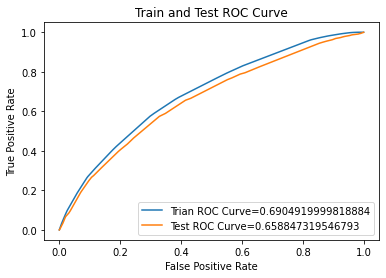

In [ ]:
sns.lineplot(fpr_trainset , tpr_trainset , label=f'Trian ROC Curve={auc_score_set1_train}')
sns.lineplot(fpr_testset , tpr_testset , label=f'Test ROC Curve={auc_score_set1_test}')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
threshold =  thresholds_train[np.argmax(tpr_trainset*(1-fpr_trainset))]
print('Probability Threshold:',threshold)

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding >= threshold , 1, 0)
confusion_matrix_train_set1_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('\nTrain Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set1_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding >= threshold , 1, 0)
confusion_matrix_test_set1_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set1_thresh)

Probability Threshold: 0.8607018076864651

Train Confusion Matrix after thresholding probability:
 [[0.61120635 0.38879365]
 [0.34896077 0.65103923]]

Test Confusion Matrix after thresholding probability:
 [[0.56896868 0.43103132]
 [0.35410061 0.64589939]]


<h3>Confusion Matrix</h3>

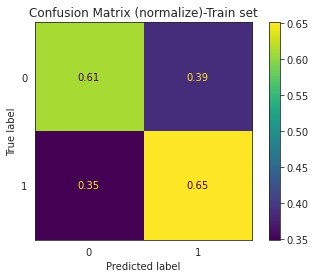

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix (normalize)-Train set')
plt.show()

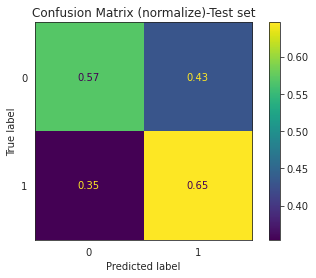

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix (normalize)-Test set')
plt.show()

<h3>Word Cloud, Prices Box Plot, Previous posted project PDF of FP points:</h3>

In [ ]:
pipe_set1.named_steps.columntransformer.output_indices_

{'tfidfvectorizer': slice(0, 47967, None),
 'sentimentscore': slice(47967, 47971, None),
 'onehotencoder': slice(47971, 48474, None),
 'minmaxscaler': slice(48474, 48476, None),
 'remainder': slice(0, 0, None)}

- for wordcloud using words having tfidf value > 0 in FP data

In [ ]:
def word_cloud_box_plot_pdf(data,X_train,y_train,y_train_after_thresholding,transformer,last_index_eassy,pipe):
  final_prob =  np.column_stack((y_train, y_train_after_thresholding))
  FP_index=[]
  for i in range(len(final_prob)):
    if final_prob[i,0]==0 and final_prob[i,1]==1:
      FP_index.append(i)  
  # word cloud
  a=transformer.transform(X_train)
  FP_data = a[FP_index]
  FP_data = FP_data.toarray()
  FP_data = FP_data[:,:last_index_eassy]
  FP_word_index=[]
  for i in FP_data:
    FP_word_index.append(np.where(i>0)[0])
  FP_word_index = np.hstack(FP_word_index)
  words=pipe.named_steps.columntransformer.named_transformers_.tfidfvectorizer.get_feature_names_out()[FP_word_index]

  word_string =''
  word_string = word_string.join(words+' ')
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(word_string)
                    
  plt.figure(figsize = (5, 5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title('Word Cloud of FP data points\n',fontsize=15)
  plt.show()

  #price boxplot
  FP_price = data.price[FP_index]
  plt.figure(figsize=(15,2))
  sns.boxplot(x=FP_price,fliersize=4,orient='h',color='green')
  plt.xlabel('Price', fontsize=12)
  patch = mpatches.Patch(color='green', label='Price') 
  plt.legend(handles=[patch])
  plt.title('\nBox Plot - FP data points - Price\n', fontsize=15)
  plt.show()

  #pdf
  FP_submit= data.teacher_number_of_previously_posted_projects[FP_index]
  plt.figure(figsize=(7,4))
  sns.kdeplot(FP_submit,cut=0)
  plt.xlabel('Previously Posted Projects', fontsize=12)
  plt.ylabel('Density', fontsize=12)
  plt.legend(labels=['PDF'])
  plt.title('\nPDF (using KDE) of FP data points for Previously Posted Projects\n',fontsize=15)
  plt.show()

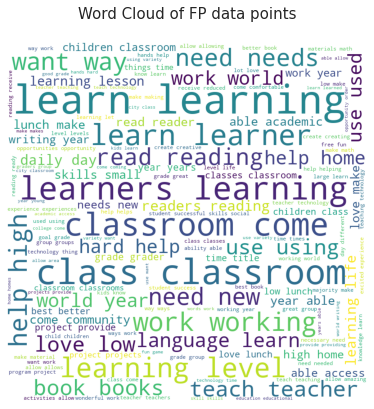

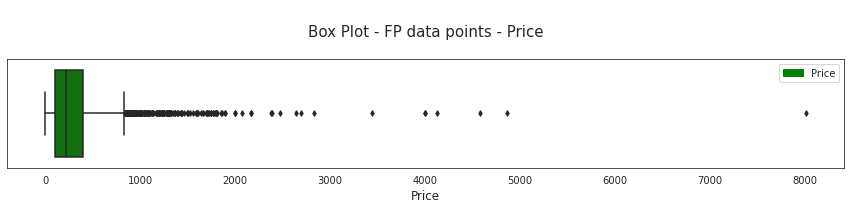

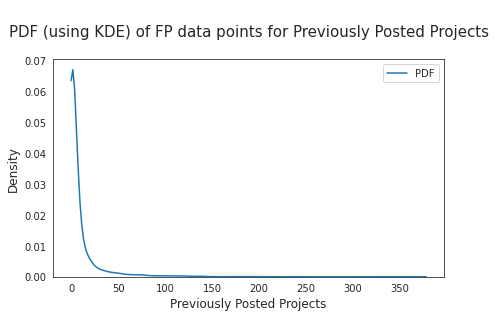

In [ ]:
last_index_eassy=47966
pipe=pipe_set1
word_cloud_box_plot_pdf(data,X_train,y_train,y_train_after_thresholding,transform_set1,last_index_eassy,pipe)

# **Set-2**

In [ ]:
transform_set2 = make_column_transformer(
    ( TfidfW2vVectorizer() , (6) ),          #tfidf-w2v on essay
    ( SentimentScore() , (6) ),
    ( OneHotEncoder(handle_unknown='ignore') , (0, 1, 2, 4, 5) ),
    ( MinMaxScaler() , (3,7) )
    )

<h3>Doing Gridsearch on Depth and min. sample split</h3>

In [ ]:
pipe_set2 = make_pipeline( transform_set2 , DecisionTreeClassifier(random_state=15) )
param = {'decisiontreeclassifier__max_depth':[1, 3, 10, 30],'decisiontreeclassifier__min_samples_split':[5, 10, 100, 500]}
clf_set2 = GridSearchCV( pipe_set2, param , cv=3, scoring='roc_auc', return_train_score=True,refit=False, error_score='raise',verbose=4) 
clf_set2.fit(X_train,y_train)

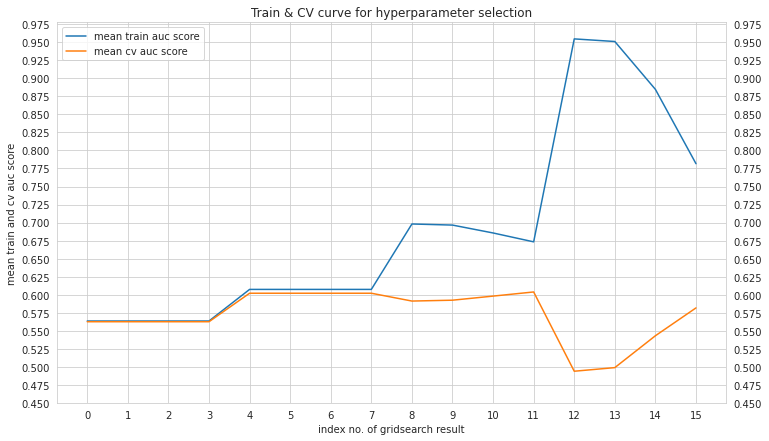

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(16), y=clf_set2.cv_results_['mean_train_score'], label='mean train auc score')
sns.lineplot(np.arange(16), y=clf_set2.cv_results_['mean_test_score'], label='mean cv auc score')
plt.xticks(np.arange(16))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index no. of gridsearch result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

Selecting Index No. 7

In [ ]:
print('Maximum Depth:',clf_set2.cv_results_['param_decisiontreeclassifier__max_depth'][7])
print('Minimum Sample Split:',clf_set2.cv_results_['param_decisiontreeclassifier__min_samples_split'][7])
print('Train AUC:',clf_set2.cv_results_['mean_train_score'][7])
print('Test AUC:',clf_set2.cv_results_['mean_test_score'][7])

Maximum Depth: 3
Minimum Sample Split: 500
Train AUC: 0.6072787419626892
Test AUC: 0.6019766426863066


<h3>Heatmap</h3>

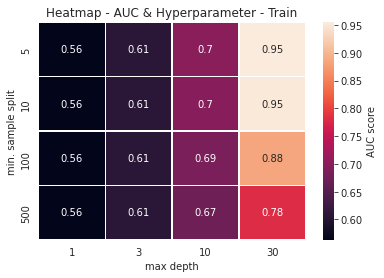

In [ ]:
auc = clf_set2.cv_results_['mean_train_score'].reshape(4,4).T
df = pd.DataFrame(auc,index=['5','10','100','500'], columns=['1','3','10','30'])
sns.heatmap(df,annot=True,linewidths=.3, cbar_kws={'label': 'AUC score'})
plt.title('Heatmap - AUC & Hyperparameter - Train')
plt.xlabel('max depth')
plt.ylabel('min. sample split')
plt.show()

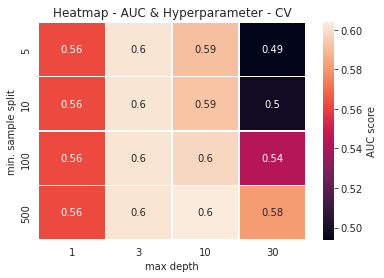

In [ ]:
auc = clf_set2.cv_results_['mean_test_score'].reshape(4,4).T
df = pd.DataFrame(auc,index=['5','10','100','500'], columns=['1','3','10','30'])
sns.heatmap(df,annot=True,linewidths=.3, cbar_kws={'label': 'AUC score'}) #https://stackoverflow.com/questions/45690898/create-a-heatmap-using-python
plt.title('Heatmap - AUC & Hyperparameter - CV')
plt.xlabel('max depth')
plt.ylabel('min. sample split')
plt.show()

<h3>Training on whole X_train:</h3>

In [ ]:
param={'decisiontreeclassifier__max_depth':3, 'decisiontreeclassifier__min_samples_split':500}

pipe_set2.set_params(**param)
pipe_set2.fit(X_train,y_train)
y_predict_train = pipe_set2.predict_proba(X_train)[:,1]
y_predict_test = pipe_set2.predict_proba(X_test)[:,1]
auc_score_set2_train = roc_auc_score(y_train, y_predict_train )
auc_score_set2_test = roc_auc_score(y_test, y_predict_test )
print('Train AUC Score:', auc_score_set2_train)
print('Test AUC Score:', auc_score_set2_test )

confusion_matrix_train_set2 = confusion_matrix(y_train,pipe_set2.predict(X_train),normalize='true')
print('Confusion Matrix - Train:\n',confusion_matrix_train_set2)
confusion_matrix_test_set2 = confusion_matrix(y_test,pipe_set2.predict(X_test),normalize='true')
print('Confusion Matrix - Test:\n',confusion_matrix_test_set2 )

Train AUC Score: 0.6068676870024995
Test AUC Score: 0.5954591582935889
Confusion Matrix - Train:
 [[0. 1.]
 [0. 1.]]
Confusion Matrix - Test:
 [[0. 1.]
 [0. 1.]]


<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_trainset, tpr_trainset, thresholds_train = roc_curve(y_train, y_predict_train)
fpr_testset, tpr_testset ,threshold_testset = roc_curve(y_test, y_predict_test)

In [ ]:
sns.lineplot(fpr_trainset , tpr_trainset , label=f'Trian ROC Curve={auc_score_set2_train}')
sns.lineplot(fpr_testset , tpr_testset , label=f'Test ROC Curve={auc_score_set2_test}')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
threshold =  thresholds_train[np.argmax(tpr_trainset*(1-fpr_trainset))]
print('Probability Threshold:',threshold)

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding >= threshold , 1, 0)
confusion_matrix_train_set2_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('\nTrain Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set2_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding >= threshold , 1, 0)
confusion_matrix_test_set2_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set2_thresh)

Probability Threshold: 0.8546870077854282

Train Confusion Matrix after thresholding probability:
 [[0.51312821 0.48687179]
 [0.36126093 0.63873907]]

Test Confusion Matrix after thresholding probability:
 [[0.50668621 0.49331379]
 [0.3725362  0.6274638 ]]


<h3>Confusion Matrix</h3>

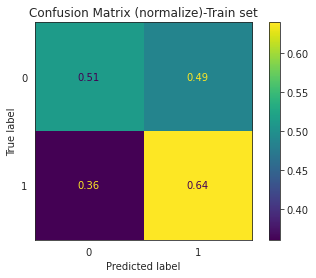

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix (normalize)-Train set')
plt.show()

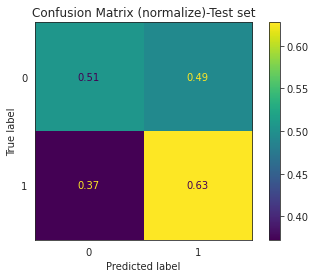

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix (normalize)-Test set')
plt.show()

<h3>Prices Box Plot, Previous posted project PDF of FP points:</h3>

- w2V weighted tfidf vector do not have eassy words as features. we can use tfidf value only for word cloud but results would be mostly similar to set1 features. so not plotting wordcloud for set2.

In [ ]:
final_prob =  np.column_stack((y_train, y_train_after_thresholding))
FP_index=[]
for i in range(len(final_prob)):
  if final_prob[i,0]==0 and final_prob[i,1]==1:
    FP_index.append(i)  

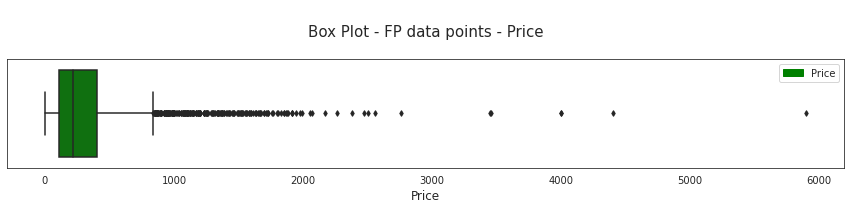

In [ ]:
FP_price = data.price[FP_index]
plt.figure(figsize=(15,2))
sns.boxplot(x=FP_price,fliersize=4,orient='h',color='green')
plt.xlabel('Price', fontsize=12)
patch = mpatches.Patch(color='green', label='Price') # https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html
plt.legend(handles=[patch])
plt.title('\nBox Plot - FP data points - Price\n', fontsize=15)
plt.show()

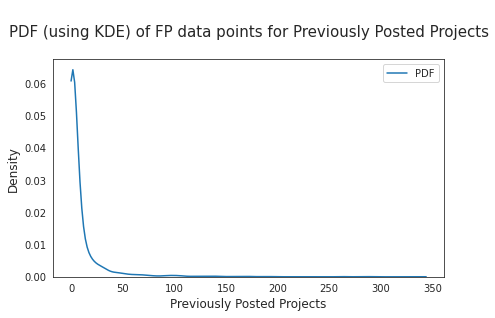

In [ ]:
FP_submit= data.teacher_number_of_previously_posted_projects[FP_index]
plt.figure(figsize=(7,4))
sns.kdeplot(FP_submit,cut=0)
plt.xlabel('Previously Posted Projects', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(labels=['PDF'])
plt.title('\nPDF (using KDE) of FP data points for Previously Posted Projects\n',fontsize=15)
plt.show()

# **Task 2**

<h3>Finding important features</h3>

In [ ]:
clf = make_pipeline( transform_set1 , DecisionTreeClassifier() )
clf.fit(X_train,y_train)
impt = clf.named_steps.decisiontreeclassifier.feature_importances_

In [ ]:
index=np.where(impt>0)

In [ ]:
print('No. of important features selected:',len(index[0]))

No. of important features selected: 3525


<h3>Training Logistic Regression</h3>

In [ ]:
X_train_impt = transform_set1.transform(X_train)[:,index[0]]
X_test_impt = transform_set1.transform(X_test)[:,index[0]]

In [ ]:
clf = SGDClassifier(loss='log', random_state=15)
param={'alpha':[.00001 , .0001 , .001 , .01 , 1 , 10 , 100 ]}
clf_lr = GridSearchCV( clf , param , cv=3, scoring='roc_auc', return_train_score=True, refit=False, error_score="raise",verbose=4)
clf_lr.fit(X_train_impt,y_train)

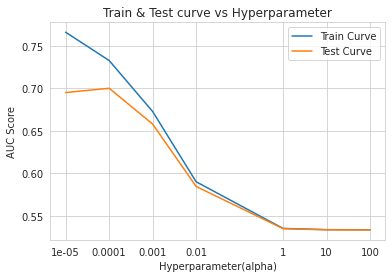

In [ ]:
sns.set_style('whitegrid')
x_log = np.log([.00001 , .0001 , .001 , .01 , 1 , 10 , 100 ])
plt.plot( x_log , clf_lr.cv_results_['mean_train_score'] )
plt.plot( x_log , clf_lr.cv_results_['mean_test_score'] )
plt.xticks( ticks=x_log , labels=[.00001 , .0001 , .001 , .01 , 1 , 10 , 100 ] )
plt.title('Train & Test curve vs Hyperparameter')
plt.ylabel('AUC Score')
plt.xlabel('Hyperparameter(alpha)')
plt.legend(labels=['Train Curve','Test Curve'])
plt.show()

Selecting alpha=0.0001

Not plotting heatmap as hyperparameter is one dimensional

<h3>Training on whole X_train</h3>

In [ ]:
clf = SGDClassifier(loss='log' , alpha=0.0001, random_state=15)
clf.fit(X_train_impt,y_train)

SGDClassifier(loss='log')

In [ ]:
y_predict_train_lr = clf.predict_proba(X_train_impt)[:,1]
y_predict_test_lr = clf.predict_proba(X_test_impt)[:,1]
auc_score_train = roc_auc_score(y_train, y_predict_train_lr )
auc_score_test = roc_auc_score(y_test, y_predict_test_lr )
print('Train AUC Score:', auc_score_train)
print('Test AUC Score:', auc_score_test )

confusion_matrix_train = confusion_matrix(y_train,clf.predict(X_train_impt),normalize='true')
print('Confusion Matrix - Train:\n',confusion_matrix_train)
confusion_matrix_test = confusion_matrix(y_test,clf.predict(X_test_impt),normalize='true')
print('Confusion Matrix - Test:\n',confusion_matrix_test )

Train AUC Score: 0.7273595780794249
Test AUC Score: 0.7054065074456944
Confusion Matrix - Train:
 [[0.01290264 0.98709736]
 [0.00130407 0.99869593]]
Confusion Matrix - Test:
 [[0.01392196 0.98607804]
 [0.00137286 0.99862714]]


In [ ]:
fpr_trainset_lr, tpr_trainset_lr, thresholds_train_lr = roc_curve(y_train, y_predict_train_lr)
fpr_testset_lr, tpr_testset_lr ,threshold_testset_lr = roc_curve(y_test, y_predict_test_lr)

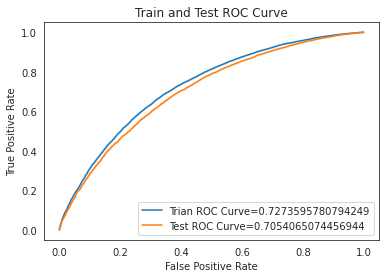

In [ ]:
sns.lineplot(fpr_trainset_lr , tpr_trainset_lr , label=f'Trian ROC Curve={auc_score_train}')
sns.lineplot(fpr_testset_lr , tpr_testset_lr , label=f'Test ROC Curve={auc_score_test}')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<h3>Finding optimal probability threshold</h3>

In [ ]:
threshold_lr =  thresholds_train_lr[np.argmax(tpr_trainset_lr*(1-fpr_trainset_lr))]
print('Probability Threshold:',threshold_lr)

y_train_after_thresholding_lr = np.copy(y_predict_train_lr)
y_train_after_thresholding_lr = np.where( y_train_after_thresholding_lr >= threshold_lr , 1, 0)
confusion_matrix_train_thresh = confusion_matrix(y_train,y_train_after_thresholding_lr,normalize='true')
print('\nTrain Confusion Matrix after thresholding probability:\n',confusion_matrix_train_thresh)

y_test_after_thresholding_lr = np.copy(y_predict_test_lr)
y_test_after_thresholding_lr = np.where( y_test_after_thresholding_lr >= threshold_lr , 1, 0)
confusion_matrix_test_thresh = confusion_matrix(y_test,y_test_after_thresholding_lr,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_thresh)

Probability Threshold: 0.8148190009199013

Train Confusion Matrix after thresholding probability:
 [[0.65929802 0.34070198]
 [0.3162784  0.6837216 ]]

Test Confusion Matrix after thresholding probability:
 [[0.62978568 0.37021432]
 [0.32481287 0.67518713]]


<h3>Confusion Matrix</h3>

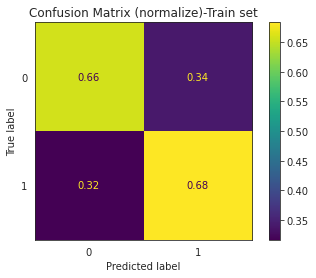

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding_lr, normalize='true')
plt.title('Confusion Matrix (normalize)-Train set')
plt.show()

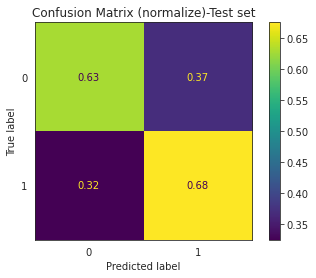

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding_lr, normalize='true')
plt.title('Confusion Matrix (normalize)-Test set')
plt.show()